# Objective: 
**To generate word vectors from the co-occurence matrix using SVD**

SVD is a technique similar to PCA and often used for dimensionality reduction. Unlike PCA, SVD can be applied to rectangular matrices.

Apart from that, you can create word vectors using SVD similar to W2V. The operation SVD returns three matrices -

* U : left singular vectors matrix
* S : singular values matrix
* V : right singular vectors matrix

Matrix U contains the word vectors we need. 

In SVD, if the matrices are n x n and you choose U,S and V of sizes n x k, k x k and k x n, it becomes truncated SVD.

In this notebook, I'll apply SVD on the co-occurence matrix of words from the Amazon food reviews. I'll then try to cluster the words using KMeans clustering.

In [1]:
%load_ext jupyternotify

<IPython.core.display.Javascript object>

Import the standard libraries.

In [93]:
import numpy as np
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import pickle
from matplotlib import rcParams
import seaborn as sbn
from scipy.spatial.distance import cosine
from sklearn.metrics.pairwise import cosine_similarity

Set figure properties

In [3]:
rcParams['figure.figsize'] = (15,4.5)

Load the cleaned dataframe containing amazon reviews from disk. 

In [43]:
con = sqlite3.connect(r'C:\Users\ucanr\Downloads\reviews_cleaned_final.sqlite')
df_full_clean = pd.read_sql('select * from Reviews;', con)
df_full_clean.head(3)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,cleaned_text
0,0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,b'bought sever vital can dog food product foun...
1,1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,b'product arriv label jumbo salt peanut peanut...
2,2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,b'confect around centuri light pillowi citru g...


Sort the dataframe by time.

In [44]:
df_full_clean.sort_values(by=['Time'], ascending=True, inplace=True)
df_full_clean.head(4)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,cleaned_text
117924,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
117901,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,b'rememb see show air televis year ago child s...
298792,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,b'beetlejuic well written movi everyth excel a...
169281,212472,230285,B00004RYGX,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",b'twist rumplestiskin captur film star michael...


Select the top 2000 reviews. I'll run `Tfidfvectorizer` only on this small subset of the total reviews. The reason for taking a small fraction of the dataset is - the calculation of the co-occurence matrix takes a lot of time. 

In [45]:
df = df_full_clean.head(2000)[['cleaned_text']]
# df = df_full_clean[['cleaned_text']]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 117924 to 303762
Data columns (total 1 columns):
cleaned_text    2000 non-null object
dtypes: object(1)
memory usage: 31.2+ KB


Gather the reviews in a list.

In [46]:
X=df['cleaned_text'].values

In [47]:
X.shape

(2000,)

### Train a Tfidf model

Select the top 2000 words by Tfidf value.

In [48]:
tfidf = TfidfVectorizer(ngram_range=(1,1), max_features=2000)

tfidf_fit = tfidf.fit(X)

X_transformed = tfidf.transform(X)

feature_array = np.array(tfidf.get_feature_names())

Some words picked up by TfidfVectorizer. 

In [49]:
feature_array[:10]

array(['abl', 'absolut', 'absorb', 'accid', 'accompani', 'accord', 'acid',
       'acquir', 'across', 'act'], dtype='<U13')

**Function to plot Elbow Curve**

In [26]:
def plot_elbow_curve(df, vector_type):
    """
        Plot the k(n_clusters) vs loss.
        The definition of the loss function can be found in the image above.
        This loss is provided by KMeans in sklearn through an attribute called "inertia_"
    """
    plt.figure(figsize=(15,6))
    plt.style.use('bmh')
    sbn.scatterplot(data=df, x='k',y='loss', color='red')
    plt.margins(0.02)
    plt.xlabel('n_clusters(K)')
    plt.ylabel('Loss')
    plt.title('{} | Elbow Curve - K vs Loss'.format(vector_type))
    plt.yscale('linear')
    plt.grid()

**function to display cluster distribution**

In [6]:
def cluster_distribution(predictions):
    
    for cluster_no in range(len(predictions)):
    
        cluster_bincounts = np.bincount(predictions[cluster_no])
        print('cluster k={} :{}'.format(len(cluster_bincounts), cluster_bincounts))

Create a list of lists, where each item in the list is a list of all the words containing in a review.

In [51]:
list_of_reviews = [ review.decode('utf-8').split() for  review in X ]

Number of items in the above list.

In [12]:
len(list_of_reviews)

2000

### Co-occurence matrix

Calculating the co-occurence matrix referring [this](https://stackoverflow.com/questions/42814452/co-occurrence-matrix-from-list-of-words-in-python) solution. The shape of the matrix is 2000 x 2000. For the top 2000 words found by Tfidf, the co-occurence is found by searching through the reviews originally selected in X.

In [ ]:
%%notify
%%time

import math

# names = ['A', 'B', 'C', 'D']
words = feature_array.tolist()

# document =[['A', 'B'], ['C', 'B', 'K'],['A', 'B', 'C', 'D', 'Z']]
documents = list_of_reviews

shape = 2000

co_oc_matrix =  np.zeros(shape=(shape, shape))

index_a = 0

for a in words:
    index_b = 0
    for b in words:
        count = 0

        for x in documents:
            if a != b:
                if a in x and b in x:
                    count += 1

            else:
                n = x.count(a)
                if n >= 2:
                    count += math.factorial(n)/math.factorial(n - 2)/2
        
        #print('{} x {} = {}'.format(a, b, count))
        co_oc_matrix[index_a, index_b] = count
        co_oc_matrix[index_b, index_a] = count
        index_b += 1
    
    print('{}'.format(a), end='|')
    
    index_a += 1

Save the cooccurnece matrix as it took a long time to build.

In [121]:
f = open(r'C:\Users\ucanr\Dropbox\AAIC\assignments mandatory\11. Word Vectors using SVD\co_oc_matrix.pkl', 'wb')
pickle.dump(co_oc_matrix, f)
f.close()

Load the saved matrix.

In [7]:
f = open(r'C:\Users\ucanr\Dropbox\AAIC\assignments mandatory\11. Word Vectors using SVD\co_oc_matrix.pkl', 'rb')
co_oc_matrix=pickle.load(f)
f.close()

In [8]:
co_oc_matrix.shape

(2000, 2000)

Let's check if the matrix is symmetric as expected.

In [9]:
def check_symmetric(a, tol=1e-8):
    return np.allclose(a, a.T, atol=tol)

check_symmetric(co_oc_matrix)

True

**Apply SVD on co-occurence matrix**

I'll use *np.linalg.svd* in Numpy for Singular Value Decomposition.

It factors the input matrix as 
> u . np.diag(s) . v

where u and v are unitary and s is a 1-d array of singular values.

In [10]:
U, S, V = np.linalg.svd(co_oc_matrix)

In [11]:
U.shape, S.shape, V.shape

((2000, 2000), (2000,), (2000, 2000))

# Choosing the right number of dimensions based on the explained variance

We'll define a function that returns the percentage of variance explained by a specified number of dimensions.


In [12]:
def percent_variance_explained(U, S, dim=1500):
    
    dim_count = 0
    denominator = np.sum(S)
    total_variance_n = 0
    total_variance_k = 0
    
    for column in range(U.shape[1]):
        
        var = np.matmul(U[:, column], U[:, column].T) / denominator
        
        total_variance_n += var
        
        if dim_count < dim:
            
            total_variance_k += var
        
        dim_count += 1
        
    
    return (total_variance_k/total_variance_n) * 100

### Plot the variance explained vs #dimensions

As can be seen in the plot, more the number of dimensions chosen, more the explained variance.

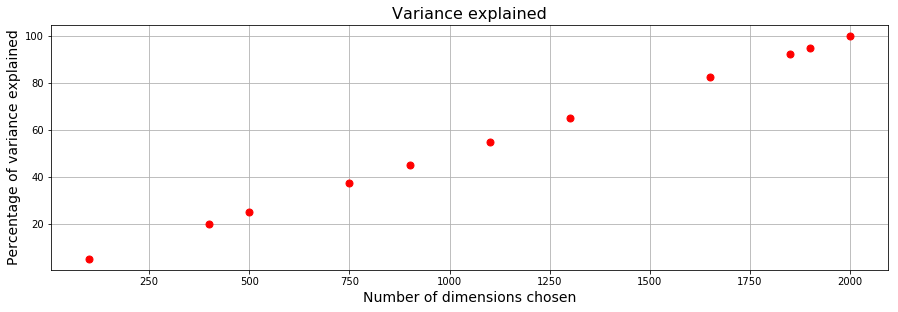

In [95]:
dimensions = [100, 400, 500, 750, 900, 1100, 1300, 1650, 1850, 1900, 2000]

_ = plt.plot(dimensions, [percent_variance_explained(U, S, dim=d) for d in dimensions], marker='.', linestyle='none', color='r', markersize=14)
plt.xlabel('Number of dimensions chosen', fontsize=14)
plt.ylabel('Percentage of variance explained', fontsize=14)
plt.title('Variance explained', fontsize=16)
plt.grid()
plt.show()

**KMeans on words**

We have the word vectors in matrix `U`. Let's cluster them using KMeans clustering. We'll try several different values of `k` ranging from 10 to 50. We will also predict the cluster number for each word in the matrix U and store them in the array `predictions`, which is a list of numpy arrays.

In [27]:
predictions=[]

dict_k_vs_loss = {'k':[], 'loss':[]}

predictions = []

#for k in [2, 3, 4, 5, 6, 7, 8]:
for k in [10, 15, 20, 25, 30, 35, 40, 45, 50]:
    kmeans = KMeans(n_clusters=k, n_jobs=2)
    # word vectors are in U
    predictions.append(kmeans.fit_predict(U))
    dict_k_vs_loss['k'].append(k)
    dict_k_vs_loss['loss'].append(kmeans.inertia_)
    
    print('done k:= {} '.format(k), end='|')

df_k_vs_loss= pd.DataFrame(dict_k_vs_loss)

done k:= 10 |done k:= 15 |done k:= 20 |done k:= 25 |done k:= 30 |done k:= 35 |done k:= 40 |done k:= 45 |done k:= 50 |

### Elbow Curve for choosing K

Let's plot a graph of `K` vs `Loss` calculated by k-means algorithm. For KMeans, this graph always has a negative slope, i.e. the loss goes on decreasing forever, so we have to stop at an appropriate value of K. 

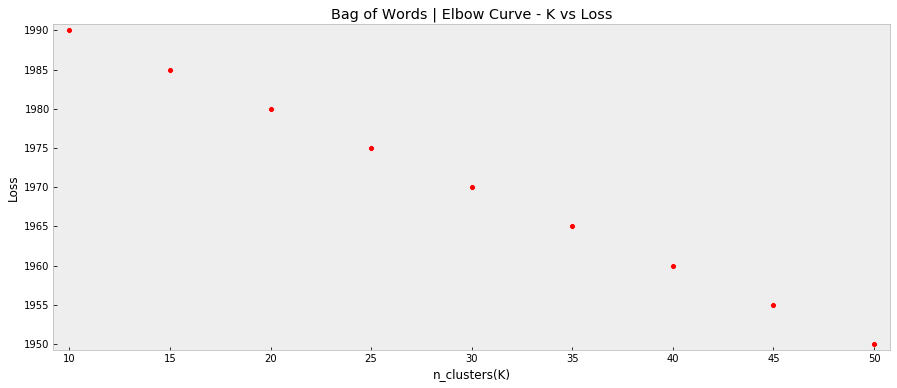

In [28]:
plot_elbow_curve(df_k_vs_loss, vector_type='Bag of Words')

## Cluster Distribution

Let's see how the clusters are distributed i.e. the number of data points in each cluster. We notice that the clusters are pretty evenly populated.

In [29]:
cluster_distribution(predictions)

cluster k=10 :[283 257 368 147 139 134 130 202 140 200]
cluster k=15 :[217 212 189 196  58  58 175 128  71  90 143 118 183 101  61]
cluster k=20 :[137 132 235 113  90  95  93  81  48  98 104  98  94 121  97  77  66  65
  70  86]
cluster k=25 :[ 52 148  80 108  98  47 138  53 128  64  48  72  80  73  78  91  43  82
  20 144  91  80  29  49 104]
cluster k=30 :[119  60  68  81  76 190  50  39 106  73 104  67  39  60  70  85  26  71
  70  57 110  40  53  45  39  33  34  32  57  46]
cluster k=35 :[ 63  63  19  97  85  52  80  90  58  56  82  37  36  52 102  22  25  37
  19  65  27  71  41  82  98  31 111  38  70  37  62  39  48  22  83]
cluster k=40 :[ 27  79  39  33  16  35  42  53  43  85  47  48  35  65  80  58  64  29
 225  24  32  40  38  30  69  25  26  65  55  18  54  28  68  29  51  52
  82  31  28  52]
cluster k=45 :[62 41 43 54 36 27 38 98 71 60 89 15 98 46 44 40 74 16 18 40 59 33 19 27
 53 21 71 25 49 56 64 50 11 23 31 39 57 28 36 25 56 27  8 91 31]
cluster k=50 :[ 94 129  31  23

### Similar Words from the same cluster

From the predictions array, let's find the words (vectors) that belong to cluster number `k`. We will plot a wordcloud of the words that belong to the same cluster for a ten cluster setup.

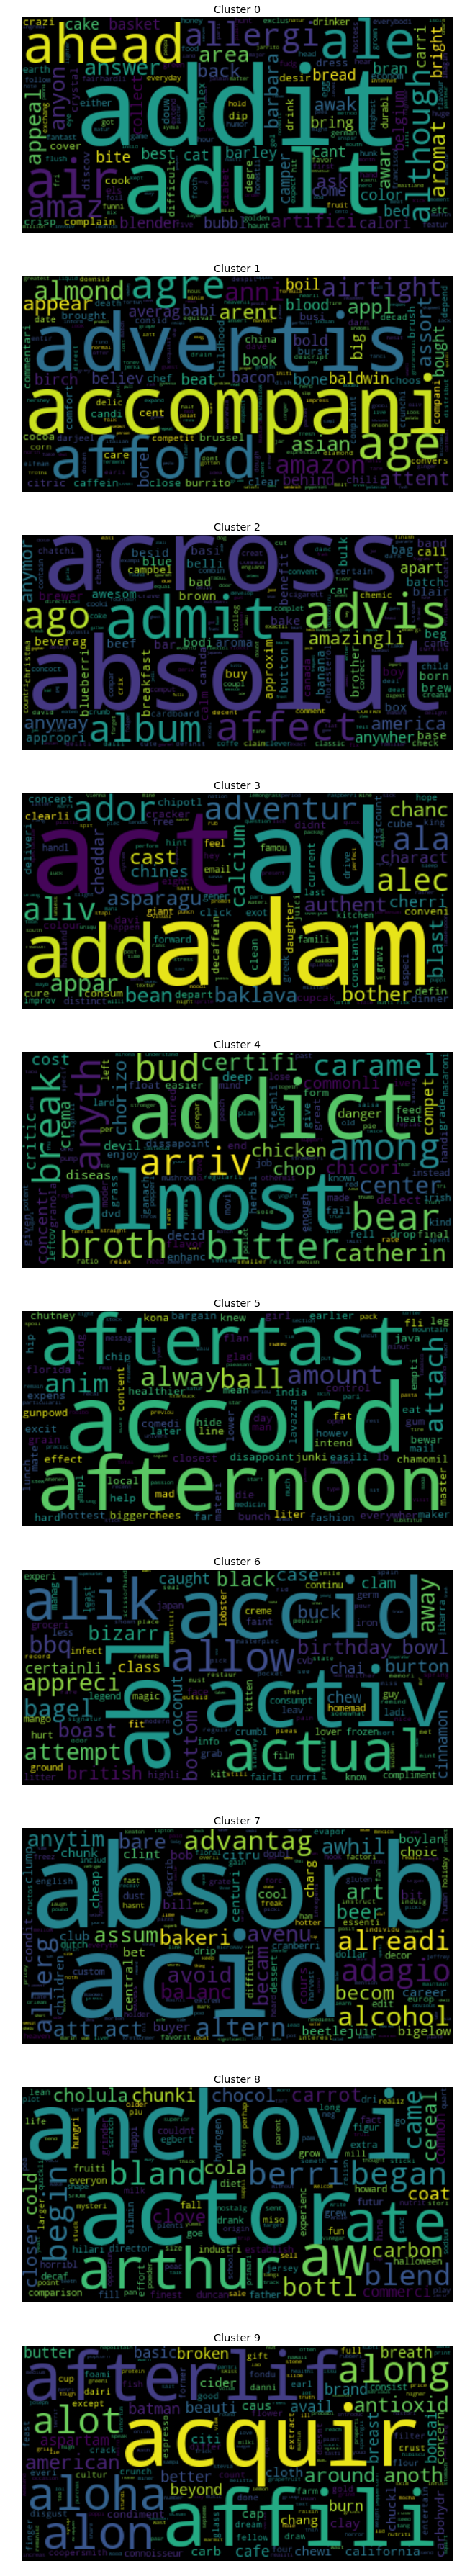

In [128]:
from operator import itemgetter

k = 0

rcParams['figure.figsize'] = (65,65)

for k in range(0,10):
    
    words_index_in_cluster_k = np.where(predictions[0] == k)
    words_in_cluster_k = itemgetter(*list(words_index_in_cluster_k[0]))(words)

    wc = WordCloud().generate(' '.join(list(words_in_cluster_k)))
    #wc = WordCloud(' '.join(list(words_in_cluster_k)))
    plt.subplot(10,1,k+1)
    plt.imshow(wc, interpolation='bilinear')
    
    _ = plt.title('Cluster {}'.format(k))
    _ = plt.axis("off")

There are a few noticeable patterns, like in 

* cluster #7, words `Acid, Alcohol, Juice, beer` are found which are all related (beverages).

* cluster #4, words `chicken, chop, broth` are found which can be related.

* cluster #0, words `crisp, barley, bread, bran` are found which are all related to bread

# Conclusion

* Calculated co-occurence matrix from the top 2000 features(words) belonging to Amazon Food Reviews.
* Applied SVD on the matrix and found left singular vectors (word vectors)
* Clustered the words vectors using KMaans clustering and created wordclouds to observe any patterns. 